In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import pandas as pd
import torch

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

from fastai.vision import *
from fastai.metrics import accuracy, Precision, Recall, FBeta
from fastai.callbacks.csv_logger import CSVLogger
from fastai.callbacks.tracker import SaveModelCallback

In [3]:
os.chdir(os.pardir)

In [4]:
from src.configs.constants import (
    CLASS_COL, IMG_COL,
    TRAIN_DF_NAME, TEST_DF_NAME,
    DATA_DIR, SAVED_DIR, WEIGHTS_FOLDER, CSV_FOLDER, TEST_FOLDER, TRAIN_FOLDER
)
from src.dataloaders.preprocess import get_indices_split

In [5]:
EXP_NAME = 'resnet50'

IMG_SIZE = 224
BATCH_SIZE = 32

# Loading Data

Visit **data block** API.

In [6]:
df = pd.read_csv(os.path.join(DATA_DIR, TRAIN_DF_NAME))
df.head()

,img_name,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,00001.jpg,39,116,569,375,Audi TTS Coupe 2012
1,00002.jpg,36,116,868,587,Acura TL Sedan 2012
2,00003.jpg,85,109,601,381,Dodge Dakota Club Cab 2007
3,00004.jpg,621,393,1484,1096,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,14,36,133,99,Ford F-450 Super Duty Crew Cab 2012


## Train/Val/Test Splits

DataBunch does the split for us.  
Consider **Stratified Split**?

In [7]:
train_idx, val_idx = get_indices_split(df, CLASS_COL, 0.2)
# 
# val_df = training_df.iloc[val_indices]
# train_df = training_df.iloc[train_indices]
# 
# print(f'Train Size: {len(train_df)}')
# print(f'Val Size: {len(val_df)}')

## Define Augmentations

Possibly too much cropping.

In [8]:
tfms = get_transforms()

## Create DataBunch

In [9]:
# Set random seed for validation split
# np.random.seed(42)

# data = ImageDataBunch.from_csv(
#     DATA_DIR,
#     folder='train',
#     csv_labels='train_labels.csv',
#     valid_pct=0.2,
#     fn_col=IMG_COL,
#     label_col=CLASS_COL,
#     ds_tfms=tfms,
#     size=IMG_SIZE,
#     bs=BATCH_SIZE
# )\
#     .normalize(imagenet_stats)

In [9]:
src = (ImageList
    .from_csv(path=DATA_DIR,
              csv_name=TRAIN_DF_NAME,
              folder=TRAIN_FOLDER,
              cols=IMG_COL)
    # stratified split
    .split_by_idxs(train_idx, val_idx)
    .label_from_df(CLASS_COL))

In [10]:
src

LabelLists;

Train: LabelList (6515 items)
x: ImageList
Image (3, 1600, 2405),Image (3, 524, 698),Image (3, 768, 1024),Image (3, 480, 640),Image (3, 480, 640)
y: CategoryList
AM General Hummer SUV 2000,Lamborghini Diablo Coupe 2001,Hyundai Tucson SUV 2012,GMC Terrain SUV 2012,Ford Focus Sedan 2007
Path: data;

Valid: LabelList (1629 items)
x: ImageList
Image (3, 480, 640),Image (3, 528, 792),Image (3, 1200, 1600),Image (3, 200, 600),Image (3, 400, 600)
y: CategoryList
Ford Ranger SuperCab 2011,Toyota 4Runner SUV 2012,Aston Martin V8 Vantage Convertible 2012,Suzuki SX4 Sedan 2012,Audi RS 4 Convertible 2008
Path: data;

Test: None

In [11]:
data = (src.transform(tfms, size=IMG_SIZE)
        .databunch(bs=BATCH_SIZE)
        .normalize(imagenet_stats))

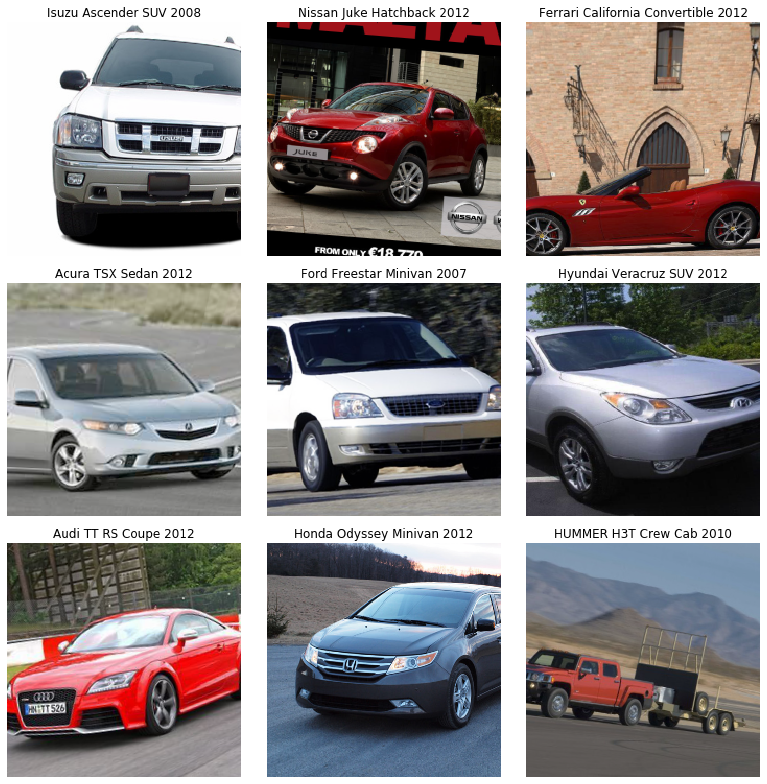

In [18]:
data.show_batch(rows=3, figsize=(11,11))

In [ ]:
len(data.classes),data.c

In [ ]:
data.train_ds

In [12]:
data.valid_ds

LabelList (1629 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Ford Ranger SuperCab 2011,Toyota 4Runner SUV 2012,Aston Martin V8 Vantage Convertible 2012,Suzuki SX4 Sedan 2012,Audi RS 4 Convertible 2008
Path: /floyd/input/data

In [ ]:
data.train_ds.x[1]

In [ ]:
data.valid_ds.y[0]

In [ ]:
np.array(data.valid_ds.y)

# Training

## Define Metrics

In [13]:
# precision = Precision('micro')
# recall = Recall('micro')
# fbeta = FBeta('micro')

In [14]:
metrics = [accuracy]

## Define Learner

In [15]:
learn = cnn_learner(
    data, 
    models.resnet50, 
    metrics=metrics, 
    path=SAVED_DIR,
    model_dir=WEIGHTS_FOLDER
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 71156547.99it/s]


## Define Callbacks

In [16]:
csv_logger = CSVLogger(
    learn,
    append=True,
    filename=os.path.join(CSV_FOLDER, EXP_NAME)
)

save_model_cb = SaveModelCallback(
    learn,
    # Also loads best model at the end of training
    every='improvement',
    name=EXP_NAME
)

In [17]:
callbacks = [csv_logger, save_model_cb]

## Stage-1

**Transfer learning**; only train the classifier head first.

Find the learning rate that results in a steep decrease in the network's loss;  
the part of the **steepest downward slope** (not the bottom), before the loss shoots up.

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-03


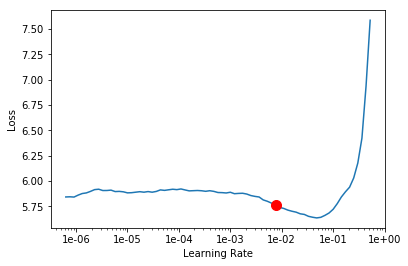

In [19]:
# Indicates the point where the gradient is the steepest
learn.recorder.plot(suggestion=True)

In [ ]:
learn.recorder.min_grad_lr

In [26]:
torch.cuda.empty_cache()

In [18]:
learn.fit_one_cycle(
    2, 
    max_lr=1e-2, 
    callbacks=callbacks
)

epoch,train_loss,valid_loss,accuracy,time
0,4.385000,3.533988,0.187845,02:45
1,2.863825,2.226642,0.443831,02:35


Better model found at epoch 0 with val_loss value: 3.533987522125244.
Better model found at epoch 1 with val_loss value: 2.226642370223999.


In [28]:
learn.save('stage-1')

## Stage 2

**Fine-tuning**; unfreeze all layers and train, but with discriminative layer training.

In [ ]:
learn.unfreeze()

**Discriminative layer training**
- Slower for earlier layers, faster for later layers, i.e. slice(start, end)
- 'start' should be inferred from the learning rate finder
    - At the bottom-ish, just before it shoots up, but 10x smaller.
- 'end' should be x5/10 smaller than lr used in Stage 1.

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-4))

In [ ]:
learn.save('stage-2')

In [ ]:
learn.recorder.plot_losses()

## Stage 3: Increasing Image Size?

Perform transfer learning with the already pretrained model with smaller image sizes.

In [ ]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

## Export Model

In [19]:
learn.export(f'{EXP_NAME}.pkl')

# Evaluation

## Plotting stuffss

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9, figsize=(15, 11))

In [ ]:
# interp.plot_confusion_matrix(figsize=(12, 12))

In [ ]:
interp.most_confused(min_val=2)

## Evaluation on Test Set

When evaluating test set, should go through the same transformations and normalization.

As specified by the competition, the model must output a confidence score for every classification.

In [23]:
test_imgs = ImageList.from_csv(
                path=DATA_DIR,
                folder=TEST_FOLDER,
                csv_name=TEST_DF_NAME,
                cols=IMG_COL)

In [29]:
test_imgs.items

array(['data\\test\\00001.jpg', 'data\\test\\00002.jpg', 'data\\test\\00003.jpg', 'data\\test\\00004.jpg', ...,
       'data\\test\\08038.jpg', 'data\\test\\08039.jpg', 'data\\test\\08040.jpg', 'data\\test\\08041.jpg'],
      dtype='<U20')

In [15]:
learn = load_learner(
    SAVED_DIR,
    f'{EXP_NAME}.pkl',
    test=test_imgs
)

**Wrong Order of Images**

In [19]:
test_df = pd.read_csv(os.path.join(DATA_DIR, TEST_DF_NAME))
test_df.head()

,img_name,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,00001.jpg,30,52,246,147,Suzuki Aerio Sedan 2007
1,00002.jpg,100,19,576,203,Ferrari 458 Italia Convertible 2012
2,00003.jpg,51,105,968,659,Jeep Patriot SUV 2012
3,00004.jpg,67,84,581,407,Toyota Camry Sedan 2012
4,00005.jpg,140,151,593,339,Tesla Model S Sedan 2012


In [20]:
print(len(test_df))

8041


In [21]:
y_true = test_df[CLASS_COL].values

In [22]:
y_true = [learn.data.classes.index(y) for y in y_true]

NameError: name 'learn' is not defined

In [23]:
y_pred, _ = learn.get_preds(ds_type=DatasetType.Test)

In [24]:
y_pred = np.argmax(y_pred, axis=1)

In [25]:
accuracy = accuracy_score(y_true, y_pred)

In [26]:
accuracy

0.45454545454545453

In [27]:
precision, recall, fscore, _ = \
    precision_recall_fscore_support(y_true, y_pred, average='micro')

In [28]:
print(precision, recall, fscore)

0.45454545454545453 0.45454545454545453 0.45454545454545453


## Test time augmentation

Take the average of our regular predictions (with weight beta) with the average of predictions obtained through augmented version of the training set (with weight 1-beta).

In [61]:
# Applies prediction using TTA
preds, y = learn.TTA(ds_type=DatasetType.Valid)

KeyboardInterrupt: 

# Log Experiment Information

Calculate validation metrics when training ends.  
Using pandas?

In [58]:
learn.csv_logger.read_logged_file()

,epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta
0,0,4.108559,3.278338,0.216697,NaN,0.216697,0.000000
1,epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta
2,0,4.223826,3.344466,0.224064,NaN,0.224064,0.000000


# Cleaning Up

Remove samples that are invalid and don't belong (for entire dataset).  
Able to also look for and remove duplicates.

In [ ]:
# Create new dataset without the split
db = (ImageList.from_folder(path)
               .no_split()
               .label_from_folder()
               .transform(get_transforms(), size=224)
               .databunch())

# And also new learner
learn_cln = cnn_learner(db, models.resnet50, metrics=accuracy)
learn_cln.load('stage-2')

ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [ ]:
from fastai.widget import *

ImageCleaner(ds, idxs, path)

# Deploying

In [ ]:
learn.export()

In [ ]:
learn = load_learner(path)

In [ ]:
img = open_image()

In [ ]:
pred_class, pred_idx, outputs = learn.predict(img)

In [ ]:
learn.pred_batch(imgs)